## Collects splotch DE genes and add to anndata object

Input files:<br>
Splotch output top genes: ST_top_gene_dict_BF0_combined.csv<br>
Anndata file: anndata_hm_norm_all_de_genes_n_Feb2022.h5ad

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import operator
import matplotlib
import scipy.stats as stats
import statsmodels.stats.multitest as multi
from collections import defaultdict
from ast import literal_eval
import scanpy as sc
from matplotlib.patches import Patch
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm
import itertools
import anndata
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 6
pd.set_option("display.max_rows", 50, "display.max_columns", 50)
sns.set_style("ticks")
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300, frameon=True, vector_friendly=True, fontsize=20, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

In [2]:
'Ignore warnings'
import warnings
warnings.filterwarnings('ignore')

Load definitions

In [3]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=grouped.groups.keys(),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out


def splotch2anndata_st_v5(
    ST_top_gene_dict,
    a,
    mode,
    n_genes = None, # sort n top genes
    conditions_order = None # sort categories
) -> None:
    
    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = mode,
                                       use_raw = False,
                                       layer = None,)
    if n_genes == None:
        n_genes = 249
    
    if mode == 'st_genotype_and_annotation_analysis':

        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] != ST_top_gene_dict['genotype_2']) & (ST_top_gene_dict['AAR2'] == ST_top_gene_dict['AAR2'] )]
        ann_pd['conds'] = [i+"_"+j for i,j in zip(ann_pd['genotype_1'],ann_pd['AAR1'])]
        a.obs['conds'] = [i+"_"+j for i,j in zip(a.obs['Genotype'],a.obs['annotation'])]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['conds'], right_on = ['conds'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'AAR1', 'conds']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['annotation', 'index_y', 'genotype_1']]
        new_anns.index = new_anns['index_y']

        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum)       
        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x','AAR1','conds'], axis = 1).rename(columns = {'annotation_y':'annotation','genotype_1_y':'genotype_1'})


        ann_pd_merged['index_y'] = ann_pd_merged.index
        ann_pd_merged['sex1_sex2'] = [i+"_"+j for i,j in zip(ann_pd_merged['genotype_1'], ann_pd_merged['annotation'])]
        means_pd_index = ann_pd_merged.groupby('sex1_sex2')['index_y'].apply(list).reset_index()

        
        if conditions_order == None:
            conditions_order = np.unique(ann_pd_merged.annotation)
        
        conditions_order_all = []
        
        for anns in conditions_order:
                if len(ann_pd_merged[ann_pd_merged.annotation == anns].groupby('genotype_1').count()) == 2:
                    conditions_order_all.append('WT_'+ anns)
                    conditions_order_all.append('GF_'+ anns)
                else:
                    continue
        
        ann_pd_merged = ann_pd_merged[ann_pd_merged['sex1_sex2'].isin(conditions_order_all)]

        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['sex1_sex2']]

        for cond in np.array(conditions_order_all):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['sex1_sex2'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('sex1_sex2')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('sex1_sex2')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('sex1_sex2')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_logbf > 0.5)] #1
            df_genes = df_genes[(df_delta > 0)]
            df_genes.dropna(axis = 0, how = 'all', inplace = True)
            df_logbf = df_logbf[df_genes.notna()]
            df_delta = df_delta[df_genes.notna()]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)

                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['sex1_sex2'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]

                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)
            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False)

        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups


    if mode == 'st_annotation_analysis_common':  
        
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] == ST_top_gene_dict['genotype_2']) & (ST_top_gene_dict['AAR2'] == 'rest')]
        ann_pd['conds'] = [i+"_"+j for i,j in zip(ann_pd['genotype_1'],ann_pd['AAR1'])]
        a.obs['conds'] = [i+"_"+j for i,j in zip(a.obs['Genotype'],a.obs['annotation'])]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['conds'], right_on = ['conds'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'AAR1', 'conds']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['annotation', 'index_y', 'genotype_1']]
        new_anns.index = new_anns['index_y']
           
        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum)     
        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x','AAR1','conds'], axis = 1).rename(columns = {'annotation_y':'annotation','genotype_1_y':'genotype_1'})

        ann_pd_merged['index_y'] = ann_pd_merged.index
        ann_pd_merged['conds'] = [i+"_"+j for i,j in zip(ann_pd_merged['genotype_1'],ann_pd_merged['annotation'])]

        #start ejre
        collect_anns = []

        for reg in np.unique(ann_pd_merged.annotation):
            ann_pd_merged_mini = ann_pd_merged.loc[(ann_pd_merged.annotation == reg)]
            ann_pd_merged_mini.drop_duplicates(subset=['conds'], inplace = True) 

            if len(ann_pd_merged_mini.index) == 2:
                # filter to only common genes
                common_genes = np.intersect1d(ann_pd_merged_mini.iloc[0,:]['genes'], ann_pd_merged_mini.iloc[1,:]['genes'])

                # get gene indexes
                common_index_0 = [i for i in enumerate(ann_pd_merged_mini.iloc[0,:]['genes']) if i[1] in common_genes]
                common_index_1 = [i for i in enumerate(ann_pd_merged_mini.iloc[1,:]['genes']) if i[1] in common_genes]

                # # order based on common genes
                genes_unique = np.array(list(zip(*common_index_0))[1])
                
                if len(common_genes) == 0:
                    continue

                for row, colname in enumerate(ann_pd_merged_mini.iterrows()):

                    logbfs = np.array(ann_pd_merged_mini.iloc[row,:]['logBFs'])
                    delta = np.array(ann_pd_merged_mini.iloc[row,:]['Delta'])

                    if row == 0:
                        pd0 = pd.DataFrame([])      
                        pd0['logbfs'] = [logbfs[i] for i in list(zip(*common_index_0))[0]]
                        pd0['delta'] =[delta[i] for i in list(zip(*common_index_0))[0]]
                        pd0.index = np.array(list(zip(*common_index_0))[1])


                    else:
                        pd1 = pd.DataFrame([]) 
                        pd1['logbfs'] = [logbfs[i] for i in list(zip(*common_index_1))[0]]
                        pd1['delta'] =[delta[i] for i in list(zip(*common_index_1))[0]]
                        pd1.index = np.array(list(zip(*common_index_1))[1])

                # collect average for each condition
                pdn = pd.merge(pd0, pd1, left_index = True, right_index = True)
                pdn['logBFs'] = pdn[['logbfs_x','logbfs_y']].mean(axis=1)
                pdn['Delta'] = pdn[['delta_x','delta_y']].mean(axis=1)
                pdn.drop(['logbfs_x','logbfs_y','delta_x','delta_y'], axis = 1, inplace = True)

                ann_pd_merged_sub = ann_pd_merged[ann_pd_merged.annotation == reg]

                for rowk, k in enumerate(ann_pd_merged_sub.iterrows()):
                    ann_pd_merged_sub.at[ann_pd_merged_sub.index[rowk], 'logBFs'] =  pdn['logBFs'].tolist()
                    ann_pd_merged_sub.at[ann_pd_merged_sub.index[rowk], 'Delta'] =  pdn['Delta'].tolist()
                    ann_pd_merged_sub.at[ann_pd_merged_sub.index[rowk], 'genes'] =  pdn.index.tolist()

                # collects new dfs
                collect_anns.append(ann_pd_merged_sub)
            else:
                continue

        ann_pd_merged = pd.concat(collect_anns)
        ann_pd_merged.index = ann_pd_merged['index_y']
        means_pd_index = ann_pd_merged.groupby('annotation')['index_y'].apply(list).reset_index()
    

        
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['annotation'])    
        ann_pd_merged = ann_pd_merged[ann_pd_merged['annotation'].isin(conditions_order)]

        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['annotation']]

        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['annotation'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('annotation')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('annotation')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('annotation')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_logbf > 0.5)] #1
            df_genes = df_genes[(df_delta > 0)]
            df_genes.dropna(axis = 0, how = 'all', inplace = True)
            df_logbf = df_logbf[df_genes.notna()]
            df_delta = df_delta[df_genes.notna()]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)

                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['annotation'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                
                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)

            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
 
        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups
    
    if mode == 'st_annotation_analysis':  

        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] == ST_top_gene_dict['genotype_2']) & (ST_top_gene_dict['AAR2'] == 'rest')]
        ann_pd['conds'] = [i+"_"+j for i,j in zip(ann_pd['genotype_1'],ann_pd['AAR1'])]
        a.obs['conds'] = [i+"_"+j for i,j in zip(a.obs['Genotype'],a.obs['annotation'])]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['conds'], right_on = ['conds'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'AAR1', 'conds']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['annotation', 'index_y', 'genotype_1']]
        new_anns.index = new_anns['index_y']
           
        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum)   
        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x','AAR1','conds'], axis = 1).rename(columns = {'genotype_1_y':'genotype_1'})
        
        ann_pd_merged['index_y'] = ann_pd_merged.index
        means_pd_index = ann_pd_merged.groupby('annotation')['index_y'].apply(list).reset_index()

        
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['annotation'])    
        ann_pd_merged = ann_pd_merged[ann_pd_merged['annotation'].isin(conditions_order)]

        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['annotation']]

        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['annotation'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('annotation')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('annotation')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('annotation')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_logbf > 0.5)] #1
            df_genes = df_genes[(df_delta > 0)]
            df_genes.dropna(axis = 0, how = 'all', inplace = True)
            df_logbf = df_logbf[df_genes.notna()]
            df_delta = df_delta[df_genes.notna()]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)

                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['annotation'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                
                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)

            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
 
        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups

    
    if mode == 'st_genotype_analysis':   
       
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] != ST_top_gene_dict['genotype_2'])]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['genotype_1'], right_on = ['Genotype'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'genotype_2', 'AAR2']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['index_y', 'genotype_1','genotype_2']]
        new_anns.index = new_anns['index_y']
           
        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum) 

        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x',], axis = 1).rename(columns = {'genotype_1_y':'genotype_1','genotype_2_y':'genotype_2'})
        ann_pd_merged['index_y'] = ann_pd_merged.index
        ann_pd_merged['sex1_sex2'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['genotype_1'], ann_pd_merged['genotype_2'])]

        means_pd_index = ann_pd_merged.groupby('sex1_sex2')['index_y'].apply(list).reset_index()

        
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['sex1_sex2'])      
        ann_pd_merged = ann_pd_merged[ann_pd_merged['sex1_sex2'].isin(conditions_order)]
        ann_pd_merged.index = ann_pd_merged['index_y']
        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['sex1_sex2']]

        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['sex1_sex2'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('sex1_sex2')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('sex1_sex2')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('sex1_sex2')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_logbf > 10)] #1
            df_genes = df_genes[(df_delta > 0)]
            df_genes = df_genes.dropna(axis = 1, how = 'all', inplace = False).drop_duplicates()
            df_logbf = df_logbf.loc[df_genes.index, df_genes.columns]
            df_delta = df_delta.loc[df_genes.index, df_genes.columns]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)

                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['sex1_sex2'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]

                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)
                
                # delete from memory 
                del marker_genes_scores
                del genes_unique
                del logbfs_unique
                del delta_unique
                del sub 
                del asub
                del genes
                del logbfs
                del delta
                del ls
                del df_genes
                del df_logbf
                del df_delta
                del tmp

            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False) #BRITTA added


        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups

def splotch2anndata_bac_v5(
    ST_top_gene_dict,
    a,
    mode,
    n_genes = None, # sort n top genes
    conditions_order = None # sort categories
) -> None:
    
    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = mode,
                                       use_raw = False,
                                       layer = None,)
    if n_genes == None:
        n_genes = 4
    
    if mode == 'bac_genotype_and_annotation_analysis':

        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] != ST_top_gene_dict['genotype_2']) & (ST_top_gene_dict['AAR2'] == ST_top_gene_dict['AAR1'])]
        ann_pd['conds'] = [i+"_"+j for i,j in zip(ann_pd['genotype_1'],ann_pd['AAR1'])]
        
        a.obs['conds'] = [i+"_"+j for i,j in zip(a.obs['Genotype'],a.obs['annotation'])]
      
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['conds'], right_on = ['conds'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'AAR1', 'conds']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['annotation', 'index_y', 'genotype_1']]
        new_anns.index = new_anns['index_y']

        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum)       
        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x','conds'], axis = 1).rename(columns = {'annotation_y':'annotation','genotype_1_y':'genotype_1'})
        ann_pd_merged['sex1_sex2'] = [i+"_"+j for i,j in zip(ann_pd_merged['genotype_1'], ann_pd_merged['annotation'])]
        means_pd_index = ann_pd_merged.groupby('sex1_sex2')['index_y'].apply(list).reset_index()
        
        if conditions_order == None:
            conditions_order = np.unique(ann_pd_merged.annotation)
        
        conditions_order_all = []
        for anns in conditions_order:
                conditions_order_all.append('WT_'+ anns)
                conditions_order_all.append('GF_'+ anns)
        
        ann_pd_merged = ann_pd_merged[ann_pd_merged['sex1_sex2'].isin(conditions_order_all)]
        ann_pd_merged.index = ann_pd_merged['index_y']
        

        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['sex1_sex2']]

        for cond in np.array(conditions_order_all):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['sex1_sex2'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('sex1_sex2')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('sex1_sex2')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('sex1_sex2')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_logbf > 0)] #1
            df_genes = df_genes[(df_delta > 0)]
            df_genes.dropna(axis = 0, how = 'all', inplace = True)
            df_logbf = df_logbf[df_genes.notna()]
            df_delta = df_delta[df_genes.notna()]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)


                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['sex1_sex2'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(marker_genes_scores)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(marker_genes_scores)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(marker_genes_scores)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(marker_genes_scores)[::-1]][0:n_genes]

                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)

            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False)

        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups


    
    if mode == 'bac_annotation_analysis':  
        
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] == ST_top_gene_dict['genotype_2']) & (ST_top_gene_dict['AAR2'] == 'rest')]
        ann_pd['conds'] = [i+"_"+j for i,j in zip(ann_pd['genotype_1'],ann_pd['AAR1'])]
        a.obs['conds'] = [i+"_"+j for i,j in zip(a.obs['Genotype'],a.obs['annotation'])]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['conds'], right_on = ['conds'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'AAR1', 'conds']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['annotation', 'index_y', 'genotype_1']]
        new_anns.index = new_anns['index_y']
           
        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum)       
        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x','AAR1','conds'], axis = 1).rename(columns = {'genotype_1_y':'genotype_1'})

        ann_pd_merged['index_y'] = ann_pd_merged.index
        means_pd_index = ann_pd_merged.groupby('annotation')['index_y'].apply(list).reset_index()

        
        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['annotation'])    
        ann_pd_merged = ann_pd_merged[ann_pd_merged['annotation'].isin(conditions_order)]

        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['annotation']]

        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['annotation'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('annotation')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('annotation')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('annotation')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_delta > 0)]
            df_genes.dropna(axis = 0, how = 'all', inplace = True)
            df_logbf = df_logbf[df_genes.notna()]
            df_delta = df_delta[df_genes.notna()]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)

                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['annotation'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                
                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)

            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
 
        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups

    
    if mode == 'bac_genotype_analysis':   
    
        ann_pd = ST_top_gene_dict[(ST_top_gene_dict['genotype_1'] != ST_top_gene_dict['genotype_2'])]
        ann_pd_merged = pd.merge(ann_pd, a.obs, left_on = ['genotype_1'], right_on = ['Genotype'])[['index_y', 'annotation', 'logBFs', 'Delta','genes','genotype_1', 'genotype_2', 'AAR2']]
        new_anns = ann_pd_merged.drop_duplicates('index_y')[['index_y', 'genotype_1','genotype_2']]
        new_anns.index = new_anns['index_y']
           
        ann_pd_merged = ann_pd_merged.groupby('index_y').agg(sum) 

        ann_pd_merged = pd.merge(ann_pd_merged, new_anns, left_index=True, right_index=True).drop(['genotype_1_x',], axis = 1).rename(columns = {'genotype_1_y':'genotype_1','genotype_2_y':'genotype_2'})
        ann_pd_merged['index_y'] = ann_pd_merged.index
        ann_pd_merged['sex1_sex2'] = [i+"_vs_"+j for i,j in zip(ann_pd_merged['genotype_1'], ann_pd_merged['genotype_2'])]

        means_pd_index = ann_pd_merged.groupby('sex1_sex2')['index_y'].apply(list).reset_index()

        if conditions_order == None: 
            conditions_order = np.unique(ann_pd_merged['sex1_sex2'])      
        ann_pd_merged = ann_pd_merged[ann_pd_merged['sex1_sex2'].isin(conditions_order)]
        ann_pd_merged.index = ann_pd_merged['index_y']
        marker_gene_means = []
        marker_genes = []
        marker_logbfs = []
        marker_delta = []
        cond_names = []
        inx_name = [i for i in ann_pd_merged['sex1_sex2']]

        for cond in np.array(conditions_order):
            if not cond in list(inx_name):
                continue

            # get relveant genes based on logBFs
            tmp = ann_pd_merged[ann_pd_merged.index.isin(means_pd_index[means_pd_index['sex1_sex2'] == cond].reset_index()['index_y'][0])]
            df_logbf = pd.DataFrame(tmp.groupby('sex1_sex2')['logBFs'].agg(lambda x: list(x))[cond])
            df_delta = pd.DataFrame(tmp.groupby('sex1_sex2')['Delta'].agg(lambda x: list(x))[cond])
            df_genes = pd.DataFrame(tmp.groupby('sex1_sex2')['genes'].agg(lambda x: list(x))[cond])
            df_genes = df_genes[(df_logbf > 0)] #1
            df_genes = df_genes[(df_delta > 0)]
            df_genes.dropna(axis = 0, how = 'all', inplace = True)
            df_logbf = df_logbf[df_genes.notna()]
            df_delta = df_delta[df_genes.notna()]

            ls = [i for i in df_genes.values.tolist()]
            genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

            # if no genes in group
            if len(genes) != 0:  
                print(cond)

                ls = [i for i in df_logbf.values.tolist()]
                logbfs = [item for sublist in ls for item in sublist if str(item) != 'nan']
                ls = [i for i in df_delta.values.tolist()]
                delta = [item for sublist in ls for item in sublist if str(item) != 'nan']

                #subset to only unique genes
                ##sunsetting fuction 
                inds = []
                seen = set()
                for i, ele in enumerate(genes):
                    if ele not in seen:
                        inds.append((i,ele))
                    seen.add(ele)

                genes_unique = np.array(list(zip(*inds))[1])
                logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
                delta_unique =[delta[i] for i in list(zip(*inds))[0]]

                # sort by descending logBFs
                genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

                #calculate average score per group 
                sub = np.unique(means_pd_index[means_pd_index['sex1_sex2'] == cond]['index_y'].iloc[0])
                asub = a[a.obs.index.isin(sub)]

                # get average score
                asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
                asub.obs['merging'] = cond
                asub.var_names_make_unique()
                marker_genes_scores = list(grouped_obs_mean(asub, group_key = 'merging').reindex(genes_unique)[cond])

                #sort by scores
                marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]
                delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:n_genes]

                # collect for all conditions
                marker_gene_means.append(marker_genes_scores)
                marker_genes.append(genes_unique)
                marker_logbfs.append(logbfs_unique)
                marker_delta.append(delta_unique)
                cond_names.append(cond)
                
                # delete from memory 
                del marker_genes_scores
                del genes_unique
                del logbfs_unique
                del delta_unique
                del sub 
                del asub
                del genes
                del logbfs
                del delta
                del ls
                del df_genes
                del df_logbf
                del df_delta
                del tmp

            else:
                continue

        df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

        rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
        rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)
        rank_genes_groups['pvals_adj'] = df_pvals_total.to_records(column_dtypes='float32',index=False) #BRITTA added


        #return a new anndata object
        print(mode)
        a.uns[mode] = rank_genes_groups

flatten = lambda t: [item for sublist in t for item in sublist]

def sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names):

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(marker_genes, index = cond_names).T
    fold_change_matrix = pd.DataFrame(marker_delta, index = cond_names).T
    pvals_change_matrix = pd.DataFrame(marker_logbfs, index = cond_names).T
    scores_change_matrix = pd.DataFrame(marker_gene_means, index = cond_names).T
    
    # filter
    df_genes_total = pd.DataFrame()
    df_scores_total = pd.DataFrame()
    df_pvals_total = pd.DataFrame()
    df_logfolds_total = pd.DataFrame()
    for colnumbs, colss in enumerate(gene_names.columns):
        sorter = gene_names[gene_names.columns[colnumbs]].tolist()
        sorter_idx = gene_names[gene_names.columns[colnumbs]].index
        tmp_genes = gene_names[(gene_names.isin(sorter))]
        tmp_scores = scores_change_matrix[(gene_names.isin(sorter))]
        tmp_pvals = pvals_change_matrix[(gene_names.isin(sorter))]
        tmp_logfolds = fold_change_matrix[(gene_names.isin(sorter))]
        df_genes = pd.DataFrame()
        df_scores = pd.DataFrame()
        df_pvals = pd.DataFrame()
        df_logfolds = pd.DataFrame()
        for colnumb, cols in enumerate(tmp_genes.columns):
            for i, val in enumerate(zip(tmp_genes[cols],tmp_scores[cols], tmp_pvals[cols], tmp_logfolds[cols])):
                if val[0] in sorter:
                    df_genes.at[sorter.index(val[0]),colnumb] = val[0]
                    df_scores.at[sorter.index(val[0]),colnumb] = val[1]
                    df_pvals.at[sorter.index(val[0]),colnumb] = val[2]
                    df_logfolds.at[sorter.index(val[0]),colnumb] = val[3]
                else:
                    df_genes.at[i,colnumb] = 'nan'
                    df_scores.at[i,colnumb] = 'nan'
                    df_pvals.at[i,colnumb] = 'nan'
                    df_logfolds.at[i,colnumb] = 'nan'
        df_genes_total = pd.concat([df_genes_total, df_genes])
        df_scores_total = pd.concat([df_scores_total, df_scores])
        df_pvals_total = pd.concat([df_pvals_total, df_pvals])
        df_logfolds_total = pd.concat([df_logfolds_total, df_logfolds])
    df_genes_total = df_genes_total.astype(object).replace('nan', np.nan)
    df_scores_total = df_scores_total.astype(object).replace('nan', np.nan) 
    df_pvals_total = df_pvals_total.astype(object).replace('nan', np.nan) 
    df_logfolds_total = df_logfolds_total.astype(object).replace('nan', np.nan) 
    df_genes_total.columns = gene_names.columns
    df_scores_total.columns = gene_names.columns
    df_pvals_total.columns = gene_names.columns
    df_logfolds_total.columns = gene_names.columns
    
    # drop rows that only contain nans
    df_genes_total.dropna(axis = 0, how = 'all', inplace = True)
    df_scores_total.dropna(axis = 0, how = 'all', inplace = True)
    df_pvals_total.dropna(axis = 0, how = 'all', inplace = True)
    df_logfolds_total.dropna(axis = 0, how = 'all', inplace = True)
    
    return df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total

    
def filter_rank_genes_groups(
    adata,
    key=None,
    key_added=None,
    min_fold_change=None,
    min_pvals_change=None,
    min_scores=None
) -> None:

    if key is None:
        key = 'rank_genes_groups'

    # convert structured numpy array into DataFrame
    gene_names = pd.DataFrame(adata.uns[key]['names'])  
    fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])
    
    # filter original_matrix
    gene_names = gene_names[(fold_change_matrix >= min_fold_change)]
    gene_names = gene_names[(pvals_change_matrix >= min_pvals_change)]
    gene_names = gene_names[(scores_change_matrix >= min_scores)]
    fold_change_matrix = fold_change_matrix[gene_names.notna()]
    pvals_change_matrix = pvals_change_matrix[gene_names.notna()]  
    scores_change_matrix = scores_change_matrix[gene_names.notna()]
    
    # remove if all rows na 
    gene_names.dropna(axis = 0, how = 'all', inplace = True)
    fold_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    pvals_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    scores_change_matrix.dropna(axis = 0, how = 'all', inplace = True)
    
    # remove if all columns na
    gene_names.dropna(axis = 1, how = 'all', inplace = True)
    fold_change_matrix.dropna(axis = 1, how = 'all', inplace = True)
    pvals_change_matrix.dropna(axis = 1, how = 'all', inplace = True)
    scores_change_matrix.dropna(axis = 1, how = 'all', inplace = True)
    
    
    # create new structured array using 'key_added'.
    adata.uns[key_added] = adata.uns[key].copy()
    adata.uns[key_added]['names'] = gene_names.to_records(index=False,column_dtypes='O')
    adata.uns[key_added]['logfoldchanges'] = fold_change_matrix.to_records(index=False,column_dtypes='float32')
    adata.uns[key_added]['pvals'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['pvals_adj'] = pvals_change_matrix.to_records(index=False,column_dtypes='float64')
    adata.uns[key_added]['scores'] = scores_change_matrix.to_records(index=False,column_dtypes='float32')


def get_marker_gene_ranges(a, key):
    
    df = pd.DataFrame(a.uns[key]['names'])
    col_rnage = []
    df_copy = df.copy()
    for i, nm in enumerate(df):

        if i == 0:
            ls = df_copy[nm].tolist()
            lapp = []
            for l in ls:
                if str(l) != 'nan':
                    lapp.append(l)
                else:
                    break
            col_rnage.append(len(lapp))
        else:
            df_copy = df_copy.iloc[len(lapp): , :]
            ls = df_copy[nm].tolist()
            lapp = []
            for l in ls:
                if str(l) != 'nan':
                    lapp.append(l)
                else:
                    break
            col_rnage.append(len(lapp))
    
    
    arange = []
    for i, nm in enumerate(col_rnage):
        if i == 0:
            arange.append(i)
        else:
            if (i + 1) > len(col_rnage):
                break
            else:
                arange.append(sum(col_rnage[:i]))
            
    return arange


def slice_df(df, startpos, gsize, arange):
    """
    Slice the data based on start position, group size and nth row
    df : pandas DataFrame
    startpos : int
        start position for the target-value (e.g. person)
    gsize : int
        group size (plus 1)
    arange : range
        slice dataframe by this defined range
    """
    i = startpos
    arange = arange
    idx = sum([list(range(i,i+gsize)) for i in arange], [])
    idx = list(filter(lambda x: x < df.shape[0], idx))
    return df.iloc[idx]

def ranges_sizes(dot_min, dot_max,smallest_dot,largest_dot):
    diff = dot_max - dot_min
    if 0.3 < diff <= 0.6:
        step = 0.1
    elif diff <= 0.3:
        step = 0.05
    else:
        step = 0.2
    # a descending range that is afterwards inverted is used
    # to guarantee that dot_max is in the legend.
    size_range = np.arange(dot_max, dot_min, step * -1)[::-1]
    if dot_min != 0 or dot_max != 1:
        dot_range = dot_max - dot_min
        size_values = (size_range - dot_min) / dot_range
    else:
        size_values = size_range
    size_exponent = 2
    size = size_values ** size_exponent
    size = size * (largest_dot - smallest_dot) + smallest_dot
    
    return size

def plot_scores_dotplot(adata, key, values_to_plot=None, dots_to_plot=None, n_genes=None, dot_min = None):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    values_to_plot - str - logfoldchanges or scores
    dots_to_plot - str - pvals or logfoldchanges
    '''

    if key == None:
        key = 'annotation_analysis'
    if values_to_plot == None:
        values_to_plot = 'logfoldchanges'
    if dots_to_plot == None:
        dots_to_plot = 'pvals'
    if n_genes == None:
        n_genes = 5
    if dot_min == None:
        dot_min = 0   

    gene_names = pd.DataFrame(adata.uns[key]['names'])
    fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
    pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
    scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])

    # selects values to plot
    if values_to_plot=='scores':
        df = scores_change_matrix
    else:
        if values_to_plot=='logfoldchanges':
            df = fold_change_matrix
        else:
            values_to_plot=='pvals'
            df = pvals_change_matrix

    # selects values to plot
    if dots_to_plot=='pvals':
        df_size = pvals_change_matrix
    else:
        if dots_to_plot=='logfoldchanges': 
            df_size = fold_change_matrix
        else:
            dots_to_plot='scores'
            df_size = scores_change_matrix

    # select top n genes from each group 
    df = slice_df(df, 0, n_genes, get_marker_gene_ranges(adata, key))
    df_size = slice_df(df_size, 0, n_genes, get_marker_gene_ranges(adata, key))
    gene_names_sliced = slice_df(gene_names, 0, n_genes, get_marker_gene_ranges(adata, key)).reset_index(drop=True)

    # drop nans
    df.index = [j for i in list(map(set,gene_names_sliced.values)) for j in i if str(j) != 'nan']

    # fill with zeros
    df = df.fillna(0).T
    df_size = df_size.fillna(0).T

    # if plotting pvals
    if dots_to_plot=='pvals':

        if dot_min == 0:
            bins = [0,0.5,1,2,3,4,100000]
            labels = [0.2,0.4,0.6,0.8,1.0,1.2]

        else:
            bins = [0,0.5,1,2,3,4,100000]
            labels = [dot_min,0.4,0.6,0.8,1.0,1.2]
        df_size_cut = pd.cut(df_size.values.flatten(), bins=bins, include_lowest = True,labels = labels )
        df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))
        df_size_cut = df_size_cut.fillna(0)

        bins_to_values = dict()
        bins_new = np.unique(df_size_cut)
        if len(bins_new) > 1:
            for r in sklearn.preprocessing.minmax_scale(ranges_sizes(dot_min, bins_new.max(), 0.0, 1.2), feature_range=(bins_new.min(), bins_new.max())):
                r = round(r, 2)
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '[0.0, 0.5]'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '[0.5, 1.0]'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '[1.0, 2.0]'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '[2.0, 3.0]'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '[3.0, 4.0]'
                if r >= 1.0:
                    bins_to_values[r] = '>4' 
            labels_axis = [j for j in bins_to_values.values()] 
        else:
            for r in ranges_sizes(0, bins_new.max(), 0.0, 1.2):
                r = bins_new[0]
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '[0.0, 0.5]'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '[0.5, 1.0]'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '[1.0, 2.0]'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '[2.0, 3.0]'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '[3.0, 4.0]'
                if r >= 1.0:
                    bins_to_values[r] = '>4' 

            labels_axis = flatten([[j for j in bins_to_values.values()] for i in ranges_sizes(0, bins_new.max(), 0.0, 1.2)])


    else:
        data = df_size.values
        scaler = MinMaxScaler()
        scaler =scaler.fit(data)
        data_t = scaler.transform(data)
        df_size_cut = pd.cut(data_t.flatten(), 6, include_lowest = True, labels = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2,])

        bins_new = np.unique(df_size_cut)
        bins_to_values = dict()
        if len(bins_new) > 1:
            for r in sklearn.preprocessing.minmax_scale(ranges_sizes(dot_min, bins_new.max(), 0.0, 1.2), feature_range=(bins_new.min(), bins_new.max())):
                r = round(r, 2)
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '<1%'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '1-20%'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '20-40%'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '40-60%'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '60-80%'
                if r >= 1.0:
                    bins_to_values[r] = '80-100%' 
            labels_axis = [j for j in bins_to_values.values()] 
        else:
            for r in ranges_sizes(0, bins_new.max(), 0.0, 1.2):
                r = bins_new[0]
                if 0 <= r <= 0.2:
                    bins_to_values[r] = '<1%'
                if 0.2 < r < 0.4:
                    bins_to_values[r] = '1-20%'
                if 0.4 <= r < 0.6:
                    bins_to_values[r] = '20-40%'
                if 0.6 <= r < 0.8:
                    bins_to_values[r] = '40-60%'
                if 0.8 <= r < 1.0:
                    bins_to_values[r] = '60-80%'
                if r >= 1.0:
                    bins_to_values[r] = '80-100%' 

            labels_axis = flatten([[j for j in bins_to_values.values()] for i in ranges_sizes(0, bins_new.max(), 0.0, 1.2)])


        df_size_cut = pd.DataFrame(zip(*[iter(df_size_cut)]*len(df_size.columns)))

    df_size_cut.columns = df.columns
    df_size_cut.index = df.index

    # remove dups
    df = df.loc[:,~df.columns.duplicated()]
    df_size_cut = df_size_cut.loc[:,~df_size_cut.columns.duplicated()]

    # check if all zeros in whole column in df_size and remove in both 
    if 'genotype_and_annotation_analysis' in key:
        df_size_cut = df_size_cut.loc[:, (df_size_cut.sum(axis=0) != 0)]
        anns_to_keep = [i.split("_")[1] for i in df_size_cut.loc[(df_size_cut.sum(axis=1) != 0), (df_size_cut.sum(axis=0) != 0)].index]
        df_size_cut_anns = []
        for an in anns_to_keep:
            df_size_cut_anns.append('WT_'+an)
            df_size_cut_anns.append('GF_'+an)
        df_size_cut = df_size_cut.loc[df_size_cut.index.isin(df_size_cut_anns),:]
    else:
        df_size_cut = df_size_cut.loc[(df_size_cut.sum(axis=1) != 0), (df_size_cut.sum(axis=0) != 0)]
    nboth = np.intersect1d(df.columns, df_size_cut.loc[(df_size_cut.sum(axis=1) != 0), (df_size_cut.sum(axis=0) != 0)].columns)
    df = df[df.columns & nboth]
    df_size_cut = df_size_cut[df_size_cut.columns & nboth]
    nboth = np.intersect1d(df.index, df_size_cut.index)
    df = df.loc[df.index & nboth,:]
    df_size_cut = df_size_cut.loc[df_size_cut.index & nboth,:]

    # define order
    cat_order = df_size_cut.index


    obs = pd.DataFrame(df.index, index = df.index, columns = ['KEGG']).astype("category")
    mod_anndata = sc.AnnData(df,obs)

    # plots
    vmin = 0.05*min(df.values.flatten())
    vmax = 0.5*max(df.values.flatten())
    cmap = 'Reds'

    category_height = 0.75
    category_width = 0.5
    legends_width = 1.0
    group_extra_size = 0.1
    min_figure_height = 6
    min_figure_width = 3


    mainplot_height = len(np.unique(mod_anndata.obs.KEGG)) * category_height
    mainplot_width = (
        len(np.unique(mod_anndata.obs.index)) * category_width + group_extra_size
    )

    height = mainplot_height + 1  # +1 for labels

    # if the number of categories is small use
    # a larger height, otherwise the legends do not fit
    height = max([min_figure_height, height])
    width = max([min_figure_width, mainplot_width]) + legends_width
    min_figure_height = height
    mainplot_height = height

    mainplot_width = width - (legends_width + group_extra_size)

    plt.rcParams['font.size'] = 10

    if dots_to_plot=='pvals':
        size_title = 'log10(BF)'
        dot_max = 1.0
    else:
        size_title = dots_to_plot
        dot_max = 0.25

    if values_to_plot=='pvals':
        colorbar_title = 'log10(BF)'
    else:
        colorbar_title = values_to_plot

    ax_dict = sc.pl.dotplot(mod_anndata, dot_min = dot_min, expression_cutoff=-0.5, show=False, var_names = mod_anndata.var_names, dot_size_df = df_size_cut, title = key,
                            dot_color_df = df, categories_order = cat_order, size_title = size_title, colorbar_title = colorbar_title,
                            groupby = 'KEGG', vmin = vmin, vmax = vmax, cmap=cmap, figsize = (mainplot_width, mainplot_height),
                           swap_axes=True)

    ax_dict['mainplot_ax'].set_yticklabels([i for i in mod_anndata.var_names]) 
    ax_dict['mainplot_ax'].tick_params(axis='y', labelleft=True, left=True, labelsize = 10, labelrotation = 0, pad = 0)   
    ax_dict['mainplot_ax'].tick_params(axis='x', labelbottom=True, bottom=True,labelsize = 10, labelrotation = 90, pad = 0) 
    ax_dict['mainplot_ax'].grid(b=True, which='major', axis='both')
    ax_dict['size_legend_ax'].set_facecolor('white')
    ax_dict['size_legend_ax'].set_aspect(0.7)
    ax_dict['color_legend_ax'].set_aspect(0.2)
    ax_dict['size_legend_ax'].set_xticklabels(labels_axis, rotation=90)

    figure = ax_dict['mainplot_ax'].get_figure()
    #figure.savefig('figures/dotplot_'+key+'.pdf', dpi=400, bbox_inches='tight')


def sort_rank_genes_st_clusters(adata, key = None, key_added = None, order = None, groupby = None):    

    # creates ranked genes object
    rank_genes_groups = dict()
    rank_genes_groups['params'] = dict(groupby = 'annotation',
                                       reference = 'rest',
                                       method = key,
                                       use_raw = False,
                                       layer = None,)
    
    if order == None:
        order = [i for i in pd.DataFrame(adata.uns[key]['names']).columns] 

    
    marker_gene_means = []
    marker_genes = []
    marker_logbfs = []
    marker_delta = []
    cond_names = []
    
    df_genes = pd.DataFrame(adata.uns[key]['names'])
    ls = [i for i in df_genes.values.tolist()]
    genes = [item for sublist in ls for item in sublist if str(item) != 'nan']

    for cond in order:

        gene_names = pd.DataFrame(adata.uns[key]['names'])
        fold_change_matrix = pd.DataFrame(adata.uns[key]['logfoldchanges'])
        pvals_change_matrix = pd.DataFrame(adata.uns[key]['pvals'])
        scores_change_matrix = pd.DataFrame(adata.uns[key]['scores'])

        # get relveant genes based on logBFs
        gene_names = gene_names[cond]
        fold_change_matrix = fold_change_matrix[cond]
        pvals_change_matrix = pvals_change_matrix[cond]
        scores_change_matrix = scores_change_matrix[cond]

        ls = [i for i in gene_names.values.tolist()]
        genes = [item for item in ls if str(item) != 'nan']
        ls = [i for i in pvals_change_matrix.values.tolist()]
        logbfs = [item for item in ls if str(item) != 'nan']
        ls = [i for i in scores_change_matrix.values.tolist()]
        delta = [item for item in ls if str(item) != 'nan']

        #subset to only unique genes
        ##sunsetting fuction 
        inds = []
        seen = set()
        for i, ele in enumerate(genes):
            if ele not in seen:
                inds.append((i,ele))
            seen.add(ele)

        genes_unique = np.array(list(zip(*inds))[1])
        logbfs_unique = [logbfs[i] for i in list(zip(*inds))[0]]
        delta_unique =[delta[i] for i in list(zip(*inds))[0]]

        # sort by descending logBFs
        genes_unique = genes_unique[np.argsort(logbfs_unique)[::-1]]
        logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]]
        delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]]

        #calculate average score per group 
        asub = adata.copy()

        # get average score
        asub = asub[:,np.unique([x for x in genes_unique if str(x) != 'nan'])]
        asub.var_names_make_unique()
        marker_genes_scores = list(grouped_obs_mean(asub, group_key = groupby).reindex(genes_unique)[cond])

        #sort by scores
        marker_genes_scores = [marker_genes_scores[i] for i in np.argsort(logbfs_unique)[::-1]][0:1999]
        genes_unique = [genes_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:1999]
        logbfs_unique = [logbfs_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:1999]
        delta_unique = [delta_unique[i] for i in np.argsort(logbfs_unique)[::-1]][0:1999]

        # collect for all conditions
        marker_gene_means.append(marker_genes_scores)
        marker_genes.append(genes_unique)
        marker_logbfs.append(logbfs_unique)
        marker_delta.append(delta_unique)
        cond_names.append(cond)
    
    df_genes_total, df_scores_total, df_pvals_total, df_logfolds_total = sort_rank_genes_group(marker_genes, marker_gene_means, marker_delta, marker_logbfs, cond_names)

    rank_genes_groups['names'] = df_genes_total.to_records(column_dtypes='O',index=False)
    rank_genes_groups['scores'] = df_scores_total.to_records(column_dtypes='float32',index=False)
    rank_genes_groups['logfoldchanges'] = df_logfolds_total.to_records(column_dtypes='float32',index=False)
    rank_genes_groups['pvals'] = df_pvals_total.to_records(column_dtypes='float32',index=False)

    #return a new anndata object
    adata.uns[key_added] = rank_genes_groups

def get_tissue_weights_bac(a, gene = None, region = None, age = None, ):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    # check if key exhists
    for_keys = gene
    
    
    a_pd_mean_list = []
    for cluster_idx in for_keys:

        #Get genes per cluster
        a_cluster = a.copy()
        genes_cluster = cluster_idx
        a_cluster = a_cluster[:,str(genes_cluster)]

         # subset to appropriate ages
        if (gene != None):
            if (region != None):
                print("Subsetting to specific genotype...")
                a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                width_fig = 5
            else:
                width_fig = 3

        # Scale data
        if gene != ['total_sum']:
            #Make sure anndata has the genes subsetted in this module aka cluster                        
            a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)

        else:
            a_scaled = a_cluster.obs.total_counts
        a_anns = a_cluster.obs.annotation
        a_conds = a_cluster.obs.conditions

        #Group anndata by condition and annotations
        a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
        a_pd.columns = ["annotation", "conditions", "value"]
        a_pd.value = a_pd.value.astype(float)
        a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()

        anns_counts = a_cluster.obs.groupby(["annotation", "conditions"]).count()
        gf_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'GF_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
        wt_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'WT_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][1]
        w = pd.DataFrame(pd.concat([gf_perc,wt_perc])['sample'])
        w = w.reindex(a_pd_mean.index)
        w.columns = ['value']
        a_pd_mean['value'] = [i*j for i,j in zip(a_pd_mean['value'],w['value'])]            

        # set unique variables for plotting
        ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
        ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
        regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

        # use the same color scale across the arrays
        a_pd_mean= a_pd_mean.round(2)
        vmin = 0.01*a_pd_mean.values.max()
        vmax = 0.99*a_pd_mean.values.max()
        a_pd_mean[a_pd_mean < vmin ] = 0
        a_pd_mean[a_pd_mean > vmax ] = vmax
        a_pd_mean.rename(columns = {'value':cluster_idx}, inplace=True)
        a_pd_mean_list.append(a_pd_mean[cluster_idx])
    
    # do some cleanups
    pop2_mean2 = pd.DataFrame(a_pd_mean_list)       
    pop2_mean2.reset_index(inplace = True)
    pop2_mean2 = pop2_mean2.T
    pop2_mean2.reset_index(inplace = True)
    obs = pop2_mean2[['annotation', 'conditions']]
    pop2_mean2 = pop2_mean2.iloc[:,2:]
    pop2_mean2.columns = pop2_mean2.iloc[0,:]
    pop2_mean2= pop2_mean2.iloc[1:,]
    obs = obs.iloc[1:,]

    alla = sc.AnnData(X=pop2_mean2, obs=obs)

    # filter over gf cutoffs
    axgf = alla[alla.obs.conditions == 'GF_6w']
    axwt = alla[alla.obs.conditions == 'WT_6w']

    # FILTER
    pop2_mean2_copy = pop2_mean2.copy()
    pop2_mean2_copy.index = obs.annotation
    total_bac_exp = np.sum(axwt.X.sum())

    region_l = []
    for region in obs.annotation.unique():
        pop2_mean2_copy_region = pop2_mean2_copy[pop2_mean2_copy.index == region]

        if region in ['pellet', 'mucosa and pellet', 'crypt apex and mucosa',
                                     'crypt base', 'crypt mid', 'crypt apex and crypt mid']:   
            cutiff = 0.3*np.max(pd.DataFrame(axgf.X).max())
        else:
            cutiff = 1*np.max(pd.DataFrame(axgf.X).max())

        pop2_mean2_copy_region[pop2_mean2_copy_region < cutiff] = 0 

        axgf_regional_bac_exp = pop2_mean2_copy_region.iloc[0,:].sum()
        axwt_regional_bac_exp = pop2_mean2_copy_region.iloc[1,:].sum()

        axgf_regional_bac = pop2_mean2_copy_region.iloc[0,:]
        axwt_regional_bac = pop2_mean2_copy_region.iloc[1,:]

        if not axwt_regional_bac_exp/total_bac_exp > 0.02:
            axwt_regional_bac[axwt_regional_bac > 0] = 0 
        if not axgf_regional_bac_exp/total_bac_exp > 0.02:
            axgf_regional_bac[axgf_regional_bac > 0] = 0

        pop2_mean2_copy_region = pd.concat([axgf_regional_bac, axwt_regional_bac], axis=1).T

        region_l.append(pop2_mean2_copy_region)

    regional_df = pd.concat(region_l)
    obs.index = obs.annotation
    obs['Genotype'] = [i.split("_")[0] for i in obs['conditions']]
    alla = sc.AnnData(X=regional_df, obs=obs)

    return alla


In [4]:
'Read in DE genes csv dict from memory'
path = ''

ST_top_gene_dict = pd.read_csv(os.path.join(path, 'ST_top_gene_dict_BF0_combined.csv'), index_col = [0], header = [0])
ST_top_gene_dict.logBFs = [literal_eval(i.replace("'", "")) for i in ST_top_gene_dict.logBFs]
ST_top_gene_dict.Delta = [literal_eval(i.replace("'", "")) for i in ST_top_gene_dict.Delta]
ST_top_gene_dict.genes = [literal_eval(i) for i in ST_top_gene_dict.genes]
ST_top_gene_dict.AAR2.replace('Rest', 'rest', inplace=True)

In [5]:
display(ST_top_gene_dict.head())
print(ST_top_gene_dict.shape)

,genotype_1,genotype_2,sex_1,sex_2,AAR1,AAR2,genes,logBFs,Delta
0,GF,GF,F,F,crypt apex and crypt mid,rest,"[Plac8, Slco6c1, Uckl1, Gm12367, Tspear, Mtmr1...","[2.0122117282095053, 1.542921882516165, 1.4583...","[0.65223562354725, 3.8131681028384583, 1.25715..."
1,GF,GF,F,F,crypt apex and mucosa,rest,"[Mtmr11, Gm32200, Scd4, Cyp2d34, Gimd1, Lyzl4o...","[0.28519925093975473, 0.029994950489092207, -0...","[0.6372250459891668, 1.2219540229105, 0.415214..."
2,GF,GF,F,F,crypt base,rest,"[Bpifc, Mapre3, Usp9y, Dydc1, Gm4955, Gm15655,...","[1.0082060694559545, 0.8305594259474725, 0.734...","[2.5167639623125004, 1.8401814456808336, 2.079..."
3,GF,GF,F,F,crypt mid,rest,"[Ydjc, Aknad1, Stard4, Rnf4, Phb, Ctc1, Smim4,...","[3.4466429431031056, 2.533555270712622, 1.4905...","[1.937673891208333, 4.860282585321833, 0.70985..."
4,GF,GF,F,F,epithelium,rest,"[Fgf23, Igkv8-31, Npr1, Gm43705, Tnfsf11, Clec...","[0.21825720536127427, -0.06046643125800337, -0...","[0.05216546580691617, 0.7135883506803333, 0.08..."


(144, 9)


Read anndata expression object

In [5]:
'Read in large anndata'
a = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))
a.var_names_make_unique()


In [6]:
'Do some clean ups'
a.obs['index'] = a.obs.index
a.obs['Age'] = '6w'
a.obs['conditions'] = [i+"_"+str(j) for i,j in zip(a.obs.Genotype, a.obs.Age)]

In [7]:
genotype_conds = []
for i in a.obs['Genotype']:
    if i == 'WT':
        genotype_conds.append('WT_vs_GF')
    else:
        genotype_conds.append('GF_vs_WT')
a.obs['genotype_conds'] = genotype_conds

## Separate anndata objects

### anndatas to contain only genes or only bacteria

In [8]:
a_st = a[:,a.var_names[a.var_names.isin([i for i in a.var_names if not 'Bacteria' in i])]]

In [9]:
'Subset to only bacs'
a_bac = a[:,a.var_names[a.var_names.isin([i for i in a.var_names if i.endswith('Bacteria')])]]
a_bac = a_bac[:,~a_bac.var_names.isin(['Lacrimispora-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria',
'Acetobacterium-Eubacteriaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria'])]
a_bac.obs['conds'] = [i+"_"+j for i,j in zip(a_bac.obs.Genotype, a_bac.obs.annotation)]



In [10]:
'Filter bacteria'
alla = get_tissue_weights_bac(a_bac, gene = a_bac.var_names.tolist(), )
alla = alla[alla.X.sum(1)>0]
alla.obs['conds'] = [i+"_"+j for i,j in zip(alla.obs.Genotype, alla.obs.annotation)]


## Separate ST_dict objects

In [11]:
ST_top_gene_dict_st = pd.DataFrame([], columns = ST_top_gene_dict.columns )
ST_top_gene_dict_bac = pd.DataFrame([], columns = ST_top_gene_dict.columns )
ST_top_gene_dict_st[['genotype_1','genotype_2','sex_1','sex_2','AAR1','AAR2']] = ST_top_gene_dict[['genotype_1','genotype_2','sex_1','sex_2','AAR1','AAR2']]
ST_top_gene_dict_bac[['genotype_1','genotype_2','sex_1','sex_2','AAR1','AAR2']] = ST_top_gene_dict[['genotype_1','genotype_2','sex_1','sex_2','AAR1','AAR2']]

for i in ST_top_gene_dict.index:
    row_genes = ST_top_gene_dict.loc[i,:]['genes']
    row_logbfs = ST_top_gene_dict.loc[i,:]['logBFs']
    row_delta = ST_top_gene_dict.loc[i,:]['Delta']
    row_gene_ind = [j for j,k in enumerate(row_genes) if not k.endswith('Bacteria')]
    row_gene_ind_bac = [j for j,k in enumerate(row_genes) if k.endswith('Bacteria')]
    # this needs to check if ind empty
    if len(row_gene_ind) > 0:
        row_genes_new = [row_genes[p] for p in row_gene_ind]
        row_logbfs_new = [row_logbfs[p] for p in row_gene_ind]
        row_delta_new = [row_delta[p] for p in row_gene_ind]
        row_gene_ind_filtered = [g for g,h in enumerate(row_logbfs_new) if h > 0]
        if len(row_gene_ind_filtered) > 0:
            row_genes_new_filtered = [row_genes_new[r] for r in row_gene_ind_filtered]
            row_logbfs_new_filtered = [row_logbfs_new[r] for r in row_gene_ind_filtered]
            row_delta_new_filtered = [row_delta_new[r] for r in row_gene_ind_filtered]
            ST_top_gene_dict_st.at[i,'genes'] = row_genes_new_filtered
            ST_top_gene_dict_st.at[i,'logBFs'] = row_logbfs_new_filtered
            ST_top_gene_dict_st.at[i,'Delta'] = row_delta_new_filtered
    else:
        ST_top_gene_dict_st.drop(i, axis = 0, inplace = True)
    
    # this needs to check if ind emptu
    if len(row_gene_ind_bac) > 0:
        row_genes_new_bac = [row_genes[r] for r in row_gene_ind_bac]
        row_logbfs_new_bac = [row_logbfs[r] for r in row_gene_ind_bac]
        row_delta_new_bac = [row_delta[r] for r in row_gene_ind_bac]
        row_gene_ind_bac_filtered = [g for g,h in enumerate(row_delta_new_bac) if h > 0]
        if len(row_gene_ind_bac_filtered) > 0:
            row_genes_new_bac_filtered = [row_genes_new_bac[r] for r in row_gene_ind_bac_filtered]
            row_logbfs_new_bac_filtered = [row_logbfs_new_bac[r] for r in row_gene_ind_bac_filtered]
            row_delta_new_bac_filtered = [row_delta_new_bac[r] for r in row_gene_ind_bac_filtered]
            ST_top_gene_dict_bac.at[i,'genes'] = row_genes_new_bac_filtered
            ST_top_gene_dict_bac.at[i,'logBFs'] = row_logbfs_new_bac_filtered
            ST_top_gene_dict_bac.at[i,'Delta'] = row_delta_new_bac_filtered
        else:
            ST_top_gene_dict_bac.drop(i, axis = 0, inplace = True)
    else:
        ST_top_gene_dict_bac.drop(i, axis = 0, inplace = True)
ST_top_gene_dict_bac = pd.concat([ST_top_gene_dict_bac[(ST_top_gene_dict_bac.AAR2 != 'rest') & (ST_top_gene_dict_bac.genotype_1 != 'GF') & (ST_top_gene_dict_bac.AAR2.isin(alla.obs.annotation))],
           ST_top_gene_dict_bac[(ST_top_gene_dict_bac.AAR2 == 'rest') & (ST_top_gene_dict_bac.genotype_1 == ST_top_gene_dict_bac.genotype_2) & (ST_top_gene_dict_bac.AAR1.isin(alla.obs.annotation))]]) #  & (ST_top_gene_dict_bac.genotype_1 != 'GF')
ST_top_gene_dict_st = ST_top_gene_dict_st.dropna()
ST_top_gene_dict_bac = ST_top_gene_dict_bac.dropna()
ST_top_gene_dict_st.reset_index(inplace = True)
ST_top_gene_dict_bac.reset_index(inplace = True)

In [12]:
ST_top_gene_dict_bac

,index,genotype_1,genotype_2,sex_1,sex_2,AAR1,AAR2,genes,logBFs,Delta
0,96,WT,GF,F,F,crypt apex and crypt mid,crypt apex and crypt mid,[Lactobacillus-Lactobacillaceae-Lactobacillale...,"[0.902249680924868, 0.669154465697726, 0.66887...","[3.4563606534125, 2.7808233719624997, 2.530106..."
1,97,WT,GF,F,F,crypt apex and mucosa,crypt apex and mucosa,[Turicibacter-Turicibacteraceae-Erysipelotrich...,"[709.782712893384, 709.782712893384, 709.78271...","[10.330522087499999, 11.40325415, 9.2908631000..."
2,98,WT,GF,F,F,crypt base,crypt base,[Lactobacillus-Lactobacillaceae-Lactobacillale...,"[276.3529316247214, 127.15804633280928, 59.649...","[8.9682017125, 8.1643795125, 7.161512237499999..."
3,99,WT,GF,F,F,crypt mid,crypt mid,[Bacteroides-Bacteroidaceae-Bacteroidales-Bact...,"[0.7386635085361322, 0.624272953848607, 0.5827...","[2.2899542417750003, 3.44553791130875, 2.28719..."
4,107,WT,GF,F,F,mucosa and pellet,mucosa and pellet,[Lactobacillus-Lactobacillaceae-Lactobacillale...,"[603.582923307474, 481.2721506877477, 439.8239...","[10.434398349999999, 9.5831057, 8.2327141625, ..."
5,110,WT,GF,F,F,pellet,pellet,[Turicibacter-Turicibacteraceae-Erysipelotrich...,"[709.782712893384, 709.782712893384, 709.78271...","[11.416631025, 11.8146140625, 6.79108447250000..."
6,112,WT,GF,F,M,crypt apex and crypt mid,crypt apex and crypt mid,[Lactobacillus-Lactobacillaceae-Lactobacillale...,"[215.91911928656606, 158.8592295560155, 151.88...","[8.48224975, 7.448306525, 7.979538675, 6.46662..."
7,113,WT,GF,F,M,crypt apex and mucosa,crypt apex and mucosa,[Blautia-Lachnospiraceae-Eubacteriales-Clostri...,"[709.782712893384, 696.6280587455819, 627.9264...","[10.382441262499999, 11.260186675, 10.05263625..."
8,114,WT,GF,F,M,crypt base,crypt base,[Lactobacillus-Lactobacillaceae-Lactobacillale...,"[385.97826868049873, 324.1841261371841, 289.16...","[9.6594224125, 8.2788487125, 8.7151246375, 7.4..."
9,115,WT,GF,F,M,crypt mid,crypt mid,[Lactobacillus-Lactobacillaceae-Lactobacillale...,"[314.1892763706198, 198.66495643383826, 106.21...","[8.4217703125, 7.4647549375, 6.487383588749999..."


In [13]:
ST_top_gene_dict_st[(ST_top_gene_dict_st.genotype_1 == ST_top_gene_dict_st.genotype_2)]

,index,genotype_1,genotype_2,sex_1,sex_2,AAR1,AAR2,genes,logBFs,Delta
0,0,GF,GF,F,F,crypt apex and crypt mid,rest,"[Plac8, Slco6c1, Uckl1, Gm12367, Tspear, Mtmr1...","[2.0122117282095053, 1.542921882516165, 1.4583...","[0.65223562354725, 3.8131681028384583, 1.25715..."
1,1,GF,GF,F,F,crypt apex and mucosa,rest,"[Mtmr11, Gm32200]","[0.28519925093975473, 0.029994950489092207]","[0.6372250459891668, 1.2219540229105]"
2,2,GF,GF,F,F,crypt base,rest,"[Bpifc, Mapre3, Usp9y, Dydc1, Gm4955, Gm15655,...","[1.0082060694559545, 0.8305594259474725, 0.734...","[2.5167639623125004, 1.8401814456808336, 2.079..."
3,3,GF,GF,F,F,crypt mid,rest,"[Ydjc, Aknad1, Stard4, Rnf4, Phb, Ctc1, Smim4,...","[3.4466429431031056, 2.533555270712622, 1.4905...","[1.937673891208333, 4.860282585321833, 0.70985..."
4,4,GF,GF,F,F,epithelium,rest,[Fgf23],[0.21825720536127427],[0.05216546580691617]
...,...,...,...,...,...,...,...,...,...,...
139,139,WT,WT,F,F,mucosa and pellet,rest,"[Saa1, Lypd8, Car4, Abcb1a, Sepp1, Hist1h1c, P...","[3.5810409565550567, 1.1435238760455382, 1.131...","[1.142071956405275, 0.5003454392266667, 0.8313..."
140,140,WT,WT,F,F,mucosae and interna,rest,"[P4ha1, Mylk3, Gm3985, Dhx32, Tmem45a, Nog, Gm...","[1.30868985066532, 1.2956374600132459, 1.14272...","[1.1789173022458332, 2.065658233677333, 2.0385..."
141,141,WT,WT,F,F,muscle and submucosa,rest,"[Cd2, Lrp8os3, Cyp4a10, Oas1g, Gm38073, 493057...","[0.2730773858106193, 0.17285301481707396, 0.16...","[1.7318922431808335, 0.30870173119785826, 0.32..."
142,142,WT,WT,F,F,pellet,rest,"[Clca1, Rbm47, Slc26a3, Saa1, Cyp2c55, Pmp22]","[2.4439504979436975, 0.6585590799053893, 0.574...","[0.31390891916666597, 0.28664277937833305, 0.3..."


## Transform splotch results

### Perform annotation analysis: one-vs-rest

Gives user information on genes specific for each annotated region irrespective of genotype (type)

In [14]:
'This might take a few minutes'
splotch2anndata_st_v5(ST_top_gene_dict = ST_top_gene_dict_st, a = a_st, mode = 'st_annotation_analysis', n_genes = 1999,
                     conditions_order = ['externa','externa and interna','interna','mucosae and interna',
                                         'epithelium and mucosae and submucosa','epithelium and mucosae',
                                         'crypt base','crypt mid','crypt apex and crypt mid',
                                         'crypt apex and mucosa','mucosa and pellet','pellet',
                                        "peyer's patch",])


externa
externa and interna
interna
mucosae and interna
epithelium and mucosae and submucosa
epithelium and mucosae
crypt base
crypt mid
crypt apex and crypt mid
crypt apex and mucosa
mucosa and pellet
pellet
peyer's patch
st_annotation_analysis


In [15]:
'This might take a few minutes'
splotch2anndata_bac_v5(ST_top_gene_dict = ST_top_gene_dict_bac, a = a_bac, mode = 'bac_annotation_analysis', n_genes = 39,
                      conditions_order = ['crypt base','crypt mid','crypt apex and crypt mid',
                                         'crypt apex and mucosa','mucosa and pellet','pellet',])


crypt base
crypt mid
crypt apex and crypt mid
crypt apex and mucosa
mucosa and pellet
pellet
bac_annotation_analysis


### Perform genotype-annotation analysis: one-vs-one (ie. changes in one MROI between genotypes)

Gives user information on genes specific for each annotated region with respect to genotype

In [16]:
'This might take a few minutes'
splotch2anndata_st_v5(ST_top_gene_dict = ST_top_gene_dict_st, a = a_st, mode = 'st_genotype_and_annotation_analysis', n_genes = 1999,
                     conditions_order = ['externa','externa and interna','interna','mucosae and interna',
                                         'epithelium and mucosae and submucosa','epithelium and mucosae',
                                         'crypt base','crypt mid','crypt apex and crypt mid',
                                         'crypt apex and mucosa','mucosa and pellet','pellet',
                                        "peyer's patch",])

WT_externa
GF_externa
WT_externa and interna
GF_externa and interna
WT_interna
GF_interna
WT_mucosae and interna
GF_mucosae and interna
WT_epithelium and mucosae and submucosa
GF_epithelium and mucosae and submucosa
WT_epithelium and mucosae
GF_epithelium and mucosae
WT_crypt base
GF_crypt base
WT_crypt mid
GF_crypt mid
WT_crypt apex and crypt mid
GF_crypt apex and crypt mid
WT_crypt apex and mucosa
GF_crypt apex and mucosa
WT_mucosa and pellet
GF_mucosa and pellet
WT_pellet
GF_pellet
WT_peyer's patch
GF_peyer's patch
st_genotype_and_annotation_analysis


In [17]:
'This might take a few minutes'
splotch2anndata_bac_v5(ST_top_gene_dict = ST_top_gene_dict_bac, a = a_bac, mode = 'bac_genotype_and_annotation_analysis', n_genes = 39,
                      conditions_order = ['crypt base','crypt mid','crypt apex and crypt mid',
                                         'crypt apex and mucosa','mucosa and pellet','pellet',])


WT_crypt base
WT_crypt mid
WT_crypt apex and crypt mid
WT_crypt apex and mucosa
WT_mucosa and pellet
WT_pellet
bac_genotype_and_annotation_analysis


### Perform genotype analysis: one-vs-rest

Gives user information on genes specific for each genotype (wt of gf)

In [18]:
'This might take a few minutes'
splotch2anndata_st_v5(ST_top_gene_dict_st, a_st, mode = 'st_genotype_analysis', n_genes = 1999)

GF_vs_WT
WT_vs_GF
st_genotype_analysis


In [19]:
'This might take a few minutes'
splotch2anndata_bac_v5(ST_top_gene_dict_bac, a_bac, mode = 'bac_genotype_analysis', n_genes = 39,)

WT_vs_GF
bac_genotype_analysis


### Filter genes based on delta (min_fold_change) and min_pvals_change (logBF)

In [20]:
# filter genes before plotting
# min_fold_change -> delta
# min_scores -> z score on expression
# min_pvals_change -> logbf
filter_rank_genes_groups(a_st,  key = 'st_genotype_analysis', min_fold_change=1, min_scores = 0, min_pvals_change = 2, key_added = 'st_genotype_analysis_filtered')
sort_rank_genes_st_clusters(a_st, key='st_genotype_analysis_filtered', key_added='st_genotype_analysis_filtered', groupby ='genotype_conds' ) 

In [21]:
# filter genes before plotting
filter_rank_genes_groups(a_st,  key = 'st_annotation_analysis', min_fold_change=0, min_scores = 0, min_pvals_change = 0.5, key_added = 'st_annotation_analysis_filtered')
sort_rank_genes_st_clusters(a_st, key='st_annotation_analysis_filtered', key_added='st_annotation_analysis_filtered', groupby = 'annotation')

In [22]:
# filter genes before plotting
filter_rank_genes_groups(a_st,  key = 'st_genotype_and_annotation_analysis', min_fold_change=3, min_scores = 0, min_pvals_change = 2, key_added = 'st_genotype_and_annotation_analysis_filtered')
sort_rank_genes_st_clusters(a_st, key='st_genotype_and_annotation_analysis_filtered', key_added='st_genotype_and_annotation_analysis_filtered', groupby = 'conds')


In [23]:
# filter genes before plotting
filter_rank_genes_groups(a_bac,  key = 'bac_genotype_and_annotation_analysis', min_fold_change=0.5, min_scores = 0, min_pvals_change = 0, key_added = 'bac_genotype_and_annotation_analysis_filtered')
sort_rank_genes_st_clusters(a_bac, key='bac_genotype_and_annotation_analysis_filtered', key_added='bac_genotype_and_annotation_analysis_filtered', groupby = 'conds')

In [24]:
# filter genes before plotting
filter_rank_genes_groups(a_bac,  key = 'bac_genotype_analysis', min_fold_change=0.5, min_scores = 0, min_pvals_change = 0, key_added = 'bac_genotype_analysis_filtered')
sort_rank_genes_st_clusters(a_bac, key='bac_genotype_analysis_filtered', key_added='bac_genotype_analysis_filtered', groupby = 'genotype_conds')


In [25]:
# filter genes before plotting
filter_rank_genes_groups(a_bac,  key = 'bac_annotation_analysis', min_fold_change=0.5, min_scores = 0, min_pvals_change = 0, key_added = 'bac_annotation_analysis_filtered')
sort_rank_genes_st_clusters(a_bac, key='bac_annotation_analysis_filtered', groupby = 'annotation', key_added='bac_annotation_analysis_filtered_n',)


## Merge back into one anndata objects

In [26]:
a_all = a_st.concatenate(a_bac, join='outer')

In [27]:
all_uns = {**a_st.uns, **a_bac.uns}

In [28]:
'Read in large anndata'
a = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))

In [29]:
a.uns = all_uns

In [30]:
'Do some clean ups'
a.obs['index'] = a.obs.index

genotype_conds = []
for i in a.obs['Genotype']:
    if i == 'WT':
        genotype_conds.append('WT_vs_GF')
    else:
        genotype_conds.append('GF_vs_WT')
a.obs['genotype_conds'] = genotype_conds

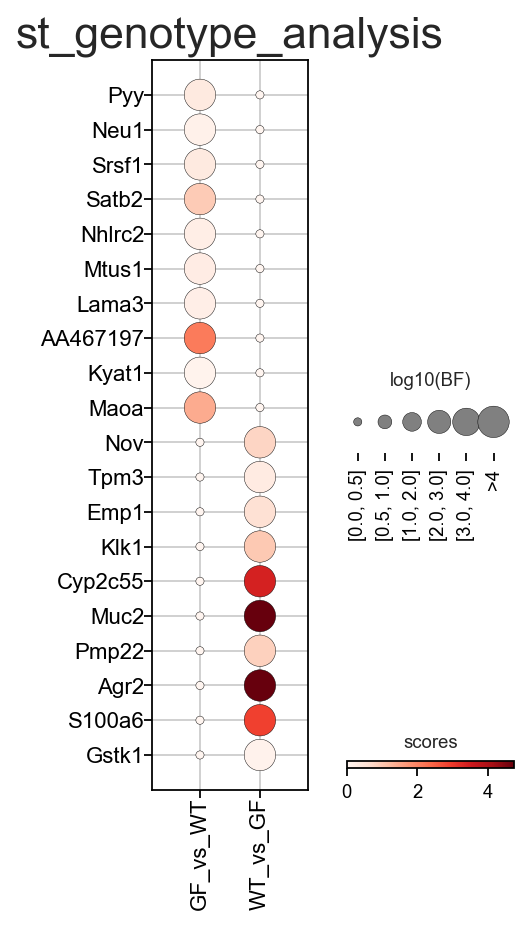

In [31]:
plot_scores_dotplot(a, 'st_genotype_analysis', n_genes = 10, values_to_plot='scores', dots_to_plot='pvals')

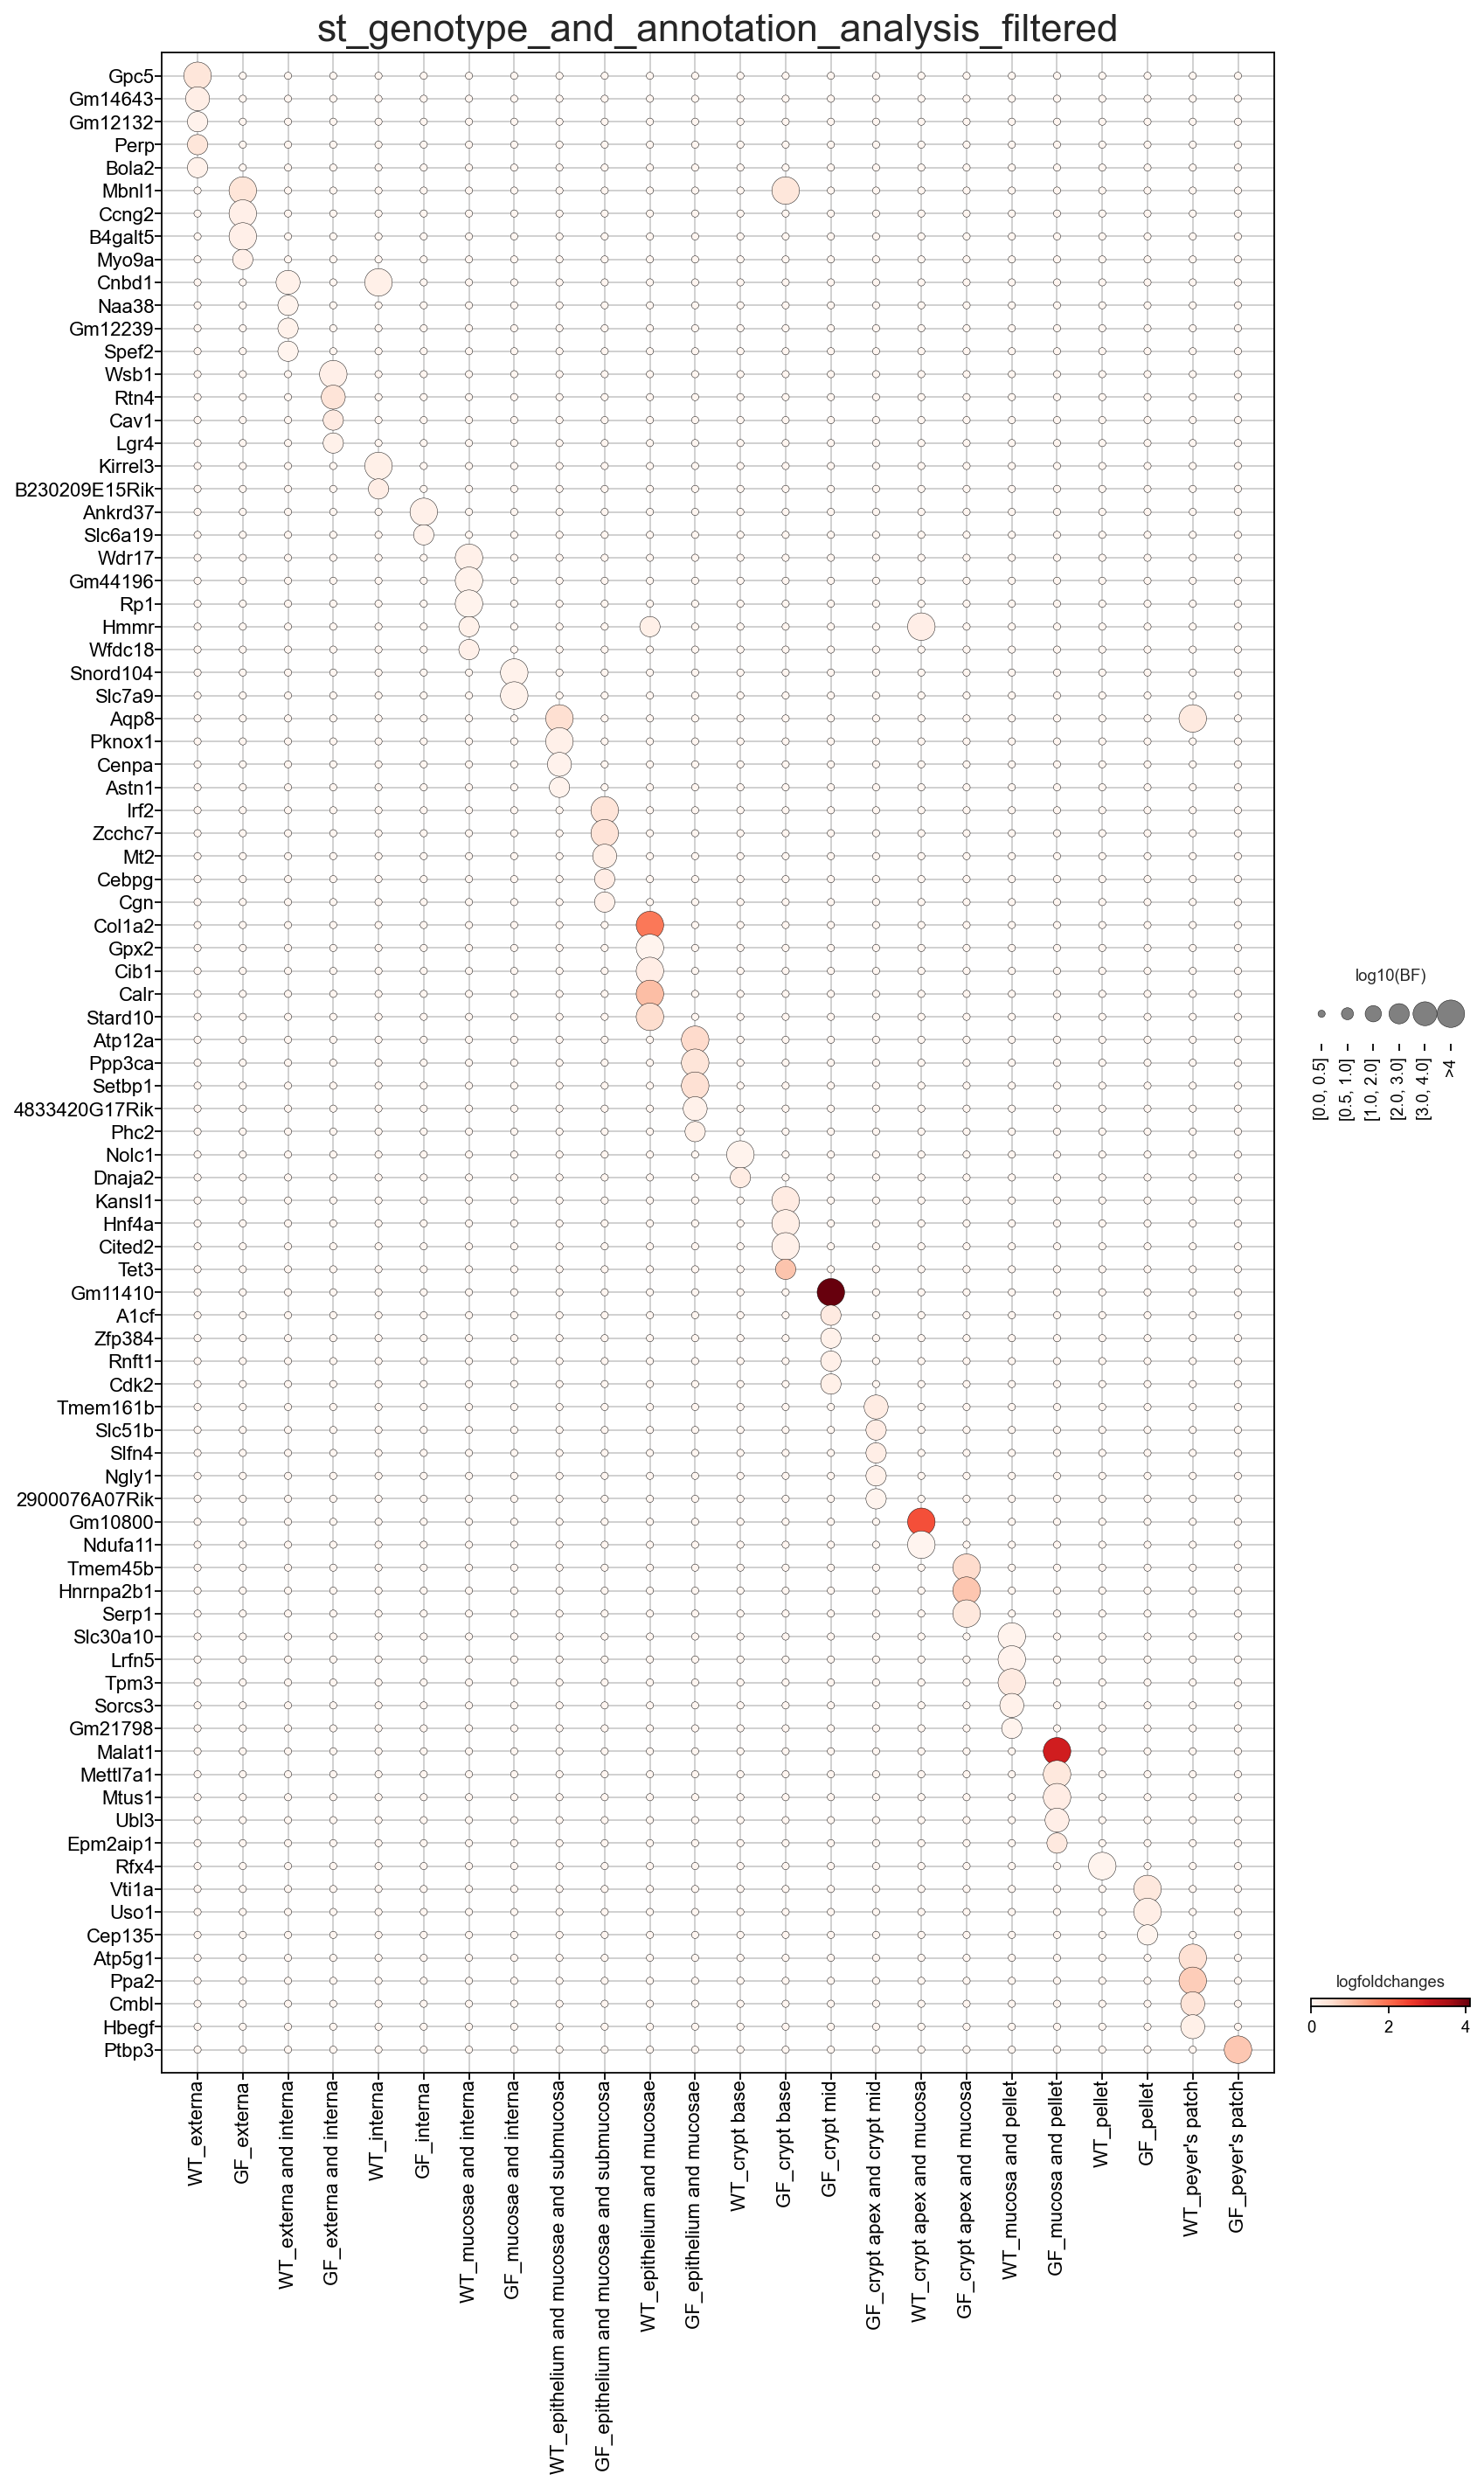

In [35]:
plot_scores_dotplot(a, 'st_genotype_and_annotation_analysis_filtered', n_genes = 5, values_to_plot='logfoldchanges', dots_to_plot='pvals', dot_min = 0)
